### A. Setups

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

import yfinance as yf
from datetime import datetime, timedelta
from scipy.stats import norm
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression

plt.style.use('seaborn-v0_8')
mpl.rcParams['font.family'] = "sans-serif"
%matplotlib inline

In [ ]:
MFST = pd.read_csv('MSFT.csv')
MFST.Date = pd.to_datetime(df["Date"], dayfirst=False)

#IntRate = pd.read_csv('1-year-gov bond.csv')
#IntRate.Date = pd.to_datetime(df['Date'], dayfirst=True)

In [9]:
MFST.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    251 non-null    datetime64[ns]
 1   Close   251 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.1 KB


### B. LSM

In [ ]:
def american_option_binomial_tree(S0, K, T, r, sigma, N):
    """
    Price an American option using the Binomial Tree method.

    Parameters:
    - S0: initial stock price
    - K: strike price
    - T: time to maturity (in years)
    - r: risk-free interest rate
    - sigma: volatility
    - N: number of steps in the binomial tree
    - option_type: "put" or "call"

    Returns:
    - Option price
    """
    from math import exp, sqrt

    # Time step
    dt = T / N
    u = exp(sigma * sqrt(dt))        # Up factor
    d = 1 / u                         # Down factor
    p = (exp(r * dt) - d) / (u - d)  # Risk-neutral probability
    discount = exp(-r * dt)

    # Initialize asset prices at maturity
    asset_prices = [S0 * (u ** j) * (d ** (N - j)) for j in range(N + 1)]

    # Initialize option values at maturity
    if option_type == "put":
        option_values = [max(K - price, 0) for price in asset_prices]
    else:  # call
        option_values = [max(price - K, 0) for price in asset_prices]

    # Backward induction
    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            asset_price = S0 * (u ** j) * (d ** (i - j))
            expected_value = discount * (p * option_values[j + 1] + (1 - p) * option_values[j])
            
            intrinsic = max(K - asset_price, 0)

            # For American options: take max of holding or early exercise
            option_values[j] = max(expected_value, intrinsic)

    return option_values[0]

In [73]:
K = np.array([np.NaN] * 9); oVal = np.array([np.NaN] * 9);
K[0] = 455; oVal[0] = 5.69
K[1] = 457.5; oVal[1] = 7.6
K[2] = 460; oVal[2] = 9.75
K[3] = 465; oVal[3] = 14.28
K[4] = 470; oVal[4] = 19.2
K[5] = 472.5; oVal[5] = 21.52
K[6] = 485; oVal[6] = 34.2
K[7] = 495; oVal[7] = 44.4
K[8] = 500; oVal[8] = 49
Sig = np.linspace(start=0.05, stop=1, num=100)

In [74]:
Sig

array([0.05      , 0.05959596, 0.06919192, 0.07878788, 0.08838384,
       0.0979798 , 0.10757576, 0.11717172, 0.12676768, 0.13636364,
       0.1459596 , 0.15555556, 0.16515152, 0.17474747, 0.18434343,
       0.19393939, 0.20353535, 0.21313131, 0.22272727, 0.23232323,
       0.24191919, 0.25151515, 0.26111111, 0.27070707, 0.28030303,
       0.28989899, 0.29949495, 0.30909091, 0.31868687, 0.32828283,
       0.33787879, 0.34747475, 0.35707071, 0.36666667, 0.37626263,
       0.38585859, 0.39545455, 0.40505051, 0.41464646, 0.42424242,
       0.43383838, 0.44343434, 0.4530303 , 0.46262626, 0.47222222,
       0.48181818, 0.49141414, 0.5010101 , 0.51060606, 0.52020202,
       0.52979798, 0.53939394, 0.5489899 , 0.55858586, 0.56818182,
       0.57777778, 0.58737374, 0.5969697 , 0.60656566, 0.61616162,
       0.62575758, 0.63535354, 0.64494949, 0.65454545, 0.66414141,
       0.67373737, 0.68333333, 0.69292929, 0.70252525, 0.71212121,
       0.72171717, 0.73131313, 0.74090909, 0.75050505, 0.76010

In [82]:
SBegin=452.91; T=15/250; nStep=50; nTraj=50000
nK = 9; nSig=len(Sig)

x = np.array([0.0] * nK * nSig)
y = np.array([0.0] * nK * nSig)
z = np.array([0.0] * nK * nSig)

cnt = -1
for i in range(0, nK):
    for j in range(0, nSig):
        cnt = int(cnt+1)
        print(cnt)
        Strike = K[i]
        x[cnt] = Sig[j]; sigma = x[cnt]
        y[cnt] = LSM_Put(SBegin, Strike, T, sigma, r, nStep, nTraj) - oVal[i]
        z[cnt] = Strike

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [86]:
y2 = np.array([0.0] * nK * nSig)
cnt = -1
for i in range(0, nK):
    for j in range(0, nSig):
        cnt = int(cnt+1)
        y2[cnt] = y[cnt] + oVal[i]

In [94]:
df = pd.DataFrame({"Sigma":x, "Val":y2, "Strike":z})
df[df.Sigma == Sig[1]]

,Sigma,Val,Strike
1,0.059596,3.554708,455.0
101,0.059596,5.253952,457.5
201,0.059596,7.299287,460.0
301,0.059596,12.079032,465.0
401,0.059596,17.078792,470.0
501,0.059596,19.578165,472.5
601,0.059596,32.081821,485.0
701,0.059596,42.078504,495.0
801,0.059596,47.078586,500.0


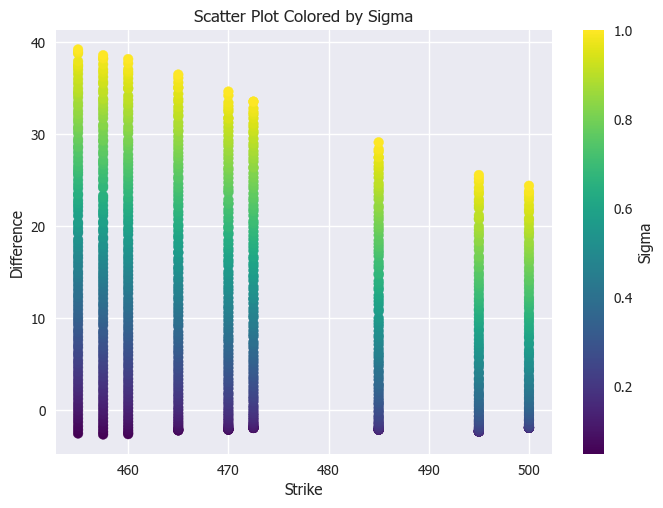

In [84]:
# Create scatter plot
fig, ax = plt.subplots()
sc = ax.scatter(z, y, c=x, cmap='viridis')  # Try 'plasma', 'inferno', etc.
cbar = fig.colorbar(sc, ax=ax)
cbar.set_label('Sigma')

ax.set_xlabel('Strike')
ax.set_ylabel('Difference')
ax.set_title('Scatter Plot Colored by Sigma')
plt.show(); plt.close()

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_11308\177606369.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('viridis')  # Or 'plasma', 'coolwarm', etc.


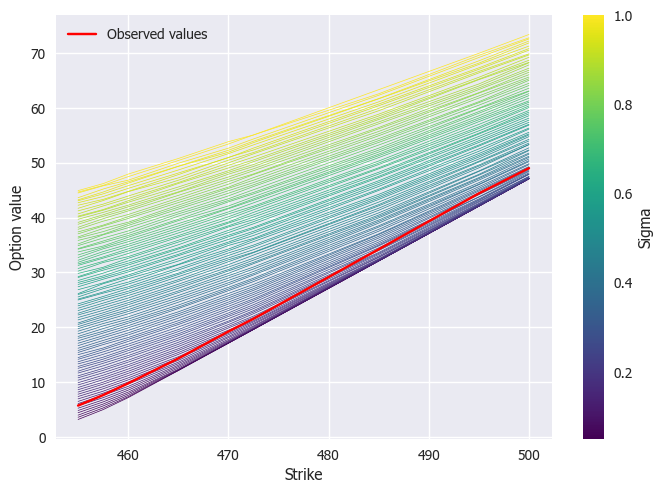

In [102]:
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize


values = Sig  # This could be any set of values for coloring
cmap = get_cmap('viridis')  # Or 'plasma', 'coolwarm', etc.
norm = Normalize(vmin=min(values), vmax=max(values))

# Plot
fig, ax = plt.subplots()
for sig in Sig:
    color = cmap(norm(sig))
    frame = df[df.Sigma == sig]
    ax.plot(frame.Strike, frame.Val, color=color, linewidth=0.5)

ax.plot(K, oVal, color="r", label="Observed values")
ax.legend()
ax.set_xlabel("Strike")
ax.set_ylabel("Option value")

# Optional: Add a colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Only needed for colorbar
plt.colorbar(sm, ax=ax, label='Sigma')

fig.savefig("SigmaPlot.png")
plt.show(); plt.close()

In [5]:
df = pd.read_csv('VN 30 Historical Data.csv')
VN30 = df["Price"].replace(',', '', regex=True).astype(float)
Date= pd.to_datetime(df["Date"])

df = pd.read_csv('1-year-gov bond.csv')
IntRate = df["Close"] 
Date2 = pd.to_datetime(df['Date'], dayfirst=True)

VN30

0      1376.91
1      1363.88
2      1373.93
3      1380.26
4      1381.47
        ...   
245    1257.78
246    1267.65
247    1274.27
248    1292.30
249    1292.62
Name: Price, Length: 250, dtype: float64

In [65]:
def GeneratePaths_Antithetic(nTraj, nStep, T, r, sigma, S0):
    """
    Note: Return a 2D ndarray of the shape 2*NbTraj * (NbStep+1)
    """
    dt = T/nStep
    dW = np.sqrt(dt) * np.random.randn(nTraj, nStep)
    dW = np.vstack((dW, -dW)); nTraj = nTraj*2

    dlnS = (r-(sigma**2)/2)*dt + sigma*dW
    lnS0 = np.log(S0) * np.ones((nTraj, 1))
    lnPaths = np.cumsum(np.hstack((lnS0, dlnS)), axis=1)
    Paths = np.exp(lnPaths)
    return Paths

def element_wise_max(x,y):
    """
    x, y are 1D ndarrays of the same length.
    Note: Return a 1D ndarray of the same length as x and y.
    """
    mat = np.vstack((x,y))
    return np.max(mat, axis=0)

def BasisFunc_Config(S):
    """
    Note:
    S is a 1D ndarray.
    Return the matrix X for regression.
    X is a 2D ndarray.
    """
    Const = np.ones(len(S))
    Basis1 = S
    Basis2 = S**2
    Basis3 = S**3
    X = np.vstack((Const, Basis1,Basis2,Basis3)).T
    return X

class LeastSquare:
    """
    X is a DataFrame.
    y is a Series.
    Output is 
    """
    def __init__(self, BasisFunc_Config, S, y):
        X = BasisFunc_Config(S)
        model = LinearRegression(fit_intercept=False)
        model.fit(X, y)
        self.coefs = model.coef_
        self.fitted = model.predict(X)

def EurPut(SBegin, Strike, T, sigma, r):
    """
    Note:
    r is the annualized continuos risk-free rate.
    sigma is the volatility of stock return per period.
    """
    import numpy as np
    from scipy.stats import norm
    d1 = (np.log(SBegin/Strike) + (r + 0.5*(sigma**2)) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    put_price = Strike * np.exp(-r * T) * norm.cdf(-d2) - SBegin * norm.cdf(-d1)
    return put_price


    
    
def LSM_Put(SBegin, Strike, T, sigma, r, nStep, nTraj):
    """
    Normalizing method to avoid numerical issue: divide prices and payoffs by the initial price
    Note1: Half of nTraj trajectories are simulated using antithetic method

    Note2:
    r is the annualized continuos risk-free rate.
    nStep is the total time intervals over T.
    """
    S0=1; K=Strike/SBegin
    #Cmt: Dividing price and pay-offs by a constant seems like a good normalizing scheme.
    #     If we scale by also minus a mean term, it would be less straight-forward when unscale it.
    
    dt=T/nStep
    DiscountFactor = np.exp(-r*T/nStep)
    #print(DiscountFactor)

    #In-sample Values
    S = GeneratePaths_Antithetic(int(nTraj/2),nStep,T,r,sigma,S0)
    Coef = np.array([np.NaN] * nStep, dtype=object)
    
    for t in range(nStep, 0, -1): #t = nStep -> 1
        St = S[:,t]
        PayOff = element_wise_max(np.zeros(nTraj), K - St)
        ITM = np.array(range(nTraj))[PayOff > 0]
        
        if t == nStep:
            Realized_PayOff = PayOff
        else:
            Realized_PayOff = Realized_PayOff * DiscountFactor
            regression = LeastSquare(BasisFunc_Config, St[ITM], Realized_PayOff[ITM])
            EPV_PayOff = regression.fitted
            Exercise = PayOff[ITM] > EPV_PayOff
            Realized_PayOff[ITM[Exercise]] = PayOff[ITM[Exercise]]
            Coef[t] = regression.coefs
        
    #InSample_Realized_PayOff = Realized_PayOff * DiscountFactor
    InSample_Realized_PayOff = Realized_PayOff * DiscountFactor * SBegin
    
    
    #Out-of-sample Values
    S = GeneratePaths_Antithetic(int(nTraj/2),nStep,T,r,sigma,S0)
    
    for t in range(nStep, 0, -1):
        St = S[:,t]
        PayOff = element_wise_max(np.zeros(nTraj), K - St)
        ITM = np.array(range(nTraj))[PayOff > 0]

        if t == nStep:
            Realized_PayOff = PayOff
        else:
            Realized_PayOff = Realized_PayOff * DiscountFactor
            EPV_PayOff = BasisFunc_Config(St[ITM]) @ Coef[t]
            Exercise = PayOff[ITM] > EPV_PayOff
            Realized_PayOff[ITM[Exercise]] = PayOff[ITM[Exercise]]

    #OutSample_Realized_PayOff = Realized_PayOff * DiscountFactor
    OutSample_Realized_PayOff = Realized_PayOff * DiscountFactor * SBegin

    #Cmt: Note that expectation and volatility function have the property that f(k*x) = k*f(x)
    #     But not the variance.
    
    #return [np.mean(InSample_Realized_PayOff), np.mean(OutSample_Realized_PayOff)]
    return np.mean(InSample_Realized_PayOff)


print(EurPut(SBegin=452.91, Strike=1350, T=1, sigma=0.2547, r=0.0203))
LSM_Put(SBegin=452.91, Strike=455, T=15/250, sigma = 0.2547, r=0.0203, nStep=50, nTraj=50000)
#print(x, y)
# .001149553

869.9618323568519


12.15430772276682

In [63]:
Strike_range = np.linspace(start=130000, stop=150000, num=100)
Eur_vals = np.array([np.NaN] * len(Strike_range))
Amer_vals = np.array([np.NaN] * len(Strike_range))

for i, Strike in enumerate(Strike_range):
    SBegin=126300; T=1; sigma=0.1342; r=0.0203; nStep=50; nTraj=80000
    
    Eur_vals[i] = EurPut(SBegin=SBegin, Strike=Strike, T=T, sigma=sigma, r=r)
    Amer_vals[i] = LSM_Put(SBegin=SBegin, Strike=Strike, T=T, sigma=sigma, r=r, nStep=nStep, nTraj=nTraj)

print(Eur_vals)
print(Amer_vals)

[ 7343.50600727  7453.2547836   7563.9074083   7675.460936
  7787.91231593  7901.25839354  8015.49591223  8130.62151509
  8246.63174663  8363.52305453  8481.29179148  8599.93421693
  8719.44649895  8839.82471608  8961.06485916  9083.16283321
  9206.11445932  9329.91547655  9454.56154384  9580.04824188
  9706.37107512  9833.52547361  9961.50679499 10090.31032644
 10219.93128657 10350.36482743 10481.60603643 10613.64993828
 10746.49149696 10880.12561766 11014.54714873 11149.7508836
 11285.73156276 11422.48387565 11560.0024626  11698.28191677
 11837.31678602 11977.10157485 12117.63074627 12258.89872368
 12400.89989276 12543.62860331 12687.07917108 12831.24587966
 12976.12298223 13121.70470339 13267.98524095 13414.95876772
 13562.6194332  13710.96136538 13859.97867244 14009.66544444
 14160.01575499 14311.02366294 14462.683214   14614.98844237
 14767.93337234 14921.51201984 15075.71839405 15230.54649888
 15385.99033452 15542.04389892 15698.70118921 15855.95620324
 16013.80294089 16172.23540

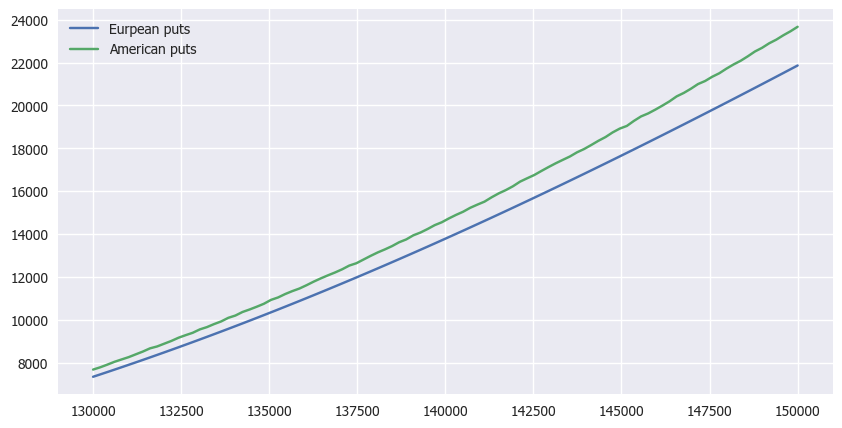

In [65]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.plot(Strike_range, Eur_vals, label="Eurpean puts")
ax.plot(Strike_range, Amer_vals , label="American puts")
ax.legend()
fig.savefig("EurVsAmer.png")
plt.show(); plt.close()

In [57]:
nPaths_range = np.arange(1, 51) * 2000
Insamples = np.array([np.NaN] * len(nPaths_range))
Outsamples = np.array([np.NaN] * len(nPaths_range))

for i, nTraj in enumerate(nPaths_range):
    SBegin=126300; Strike=130000; T=1; sigma=0.2889; r=0.0203; nStep=50
    
    Insamples[i], Outsamples[i] = LSM_Put(SBegin=SBegin, Strike=Strike, T=T, sigma=sigma, r=r, nStep=nStep, nTraj=nTraj)

print(Insamples)
print(Outsamples)

[15431.06907184 15581.25161996 15484.7495187  15409.78713704
 15380.04310187 15398.82694846 15339.09946156 15308.66262872
 15401.71061253 15389.53987047 15302.89590146 15357.28976973
 15394.83855366 15380.92480043 15452.79441425 15442.31719549
 15427.42232449 15328.6138546  15333.43565537 15405.83401182
 15388.48717917 15357.24686863 15364.93677507 15369.59538813
 15378.38426317 15410.55677542 15344.15644868 15340.30235151
 15354.4596397  15346.30237434 15366.41973697 15332.20122021
 15432.95938257 15368.64185718 15342.24962707 15388.95374821
 15354.87740708 15394.48475553 15369.75968216 15390.98070533
 15397.06051642 15405.46480865 15354.91362777 15374.40622418
 15405.41019896 15371.66585348 15354.21223544 15386.41161516
 15357.94360801 15377.20114936]
[15352.59396512 15330.38034459 15449.13251289 15297.84511429
 15325.96756933 15258.63138306 15337.60582604 15392.44307652
 15264.31004338 15413.6061331  15355.03905099 15356.87899772
 15357.9000497  15376.0582843  15334.50790367 15311.1

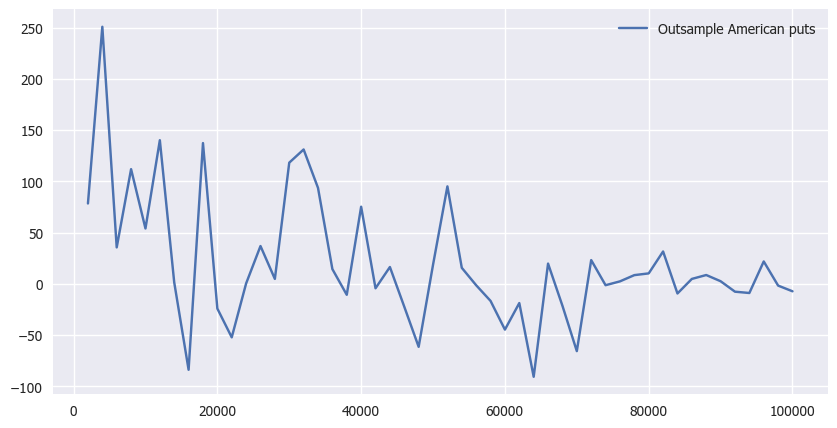

In [60]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
#ax.plot(nPaths_range, Insamples, label="Insample American puts")
ax.plot(nPaths_range, Insamples - Outsamples, label="Outsample American puts")
ax.legend()

fig.savefig("InvsOutsample.png")
plt.show(); plt.close()

In [983]:
def BasisFunc_Config(S):
    """
    Note:
    S is a 1D ndarray.
    Return the matrix X for regression.
    X is a 2D ndarray.
    """
    Const = np.ones(len(S))
    Basis1 = S
    Basis2 = S**2
    X = np.vstack((Const, Basis1,Basis2)).T
    return X

def LSM(SBegin, Strike, T, sigma, r, nStep, nTraj):
    S0=1; K=Strike/SBegin

    dt=T/nStep
    DiscountFactor = np.exp(-r*T/nStep)
    print(DiscountFactor)

    #In-sample Values
    S = GeneratePaths_Antithetic(int(nTraj/2),nStep,T,r,sigma,S0)
    S = np.array([
    [1.00, 1.09, 1.08, 1.34],
    [1.00, 1.16, 1.26, 1.54],
    [1.00, 1.22, 1.07, 1.03],
    [1.00, 0.93, 0.97, 0.92],
    [1.00, 1.11, 1.56, 1.52],
    [1.00, 0.76, 0.77, 0.90],
    [1.00, 0.92, 0.84, 1.01],
    [1.00, 0.88, 1.22, 1.34]])
    print(S)
    Coef = np.array([np.NaN] * nStep, dtype=object)

    
    for t in range(nStep, 0, -1): #t = nStep -> 1
        St = S[:,t]
        PayOff = element_wise_max(np.zeros(nTraj), K - St)
        ITM = np.array(range(nTraj))[PayOff > 0]
        
        if t == nStep:
            Realized_PayOff = PayOff
        else:
            Realized_PayOff = Realized_PayOff * DiscountFactor
            regression = LeastSquare(BasisFunc_Config, St[ITM], Realized_PayOff[ITM])
            EPV_PayOff = regression.fitted
            Exercise = PayOff[ITM] > EPV_PayOff
            Realized_PayOff[ITM[Exercise]] = PayOff[ITM[Exercise]]
            Coef[t] = regression.coefs
        

    #InSample_Realized_PayOff = Realized_PayOff * DiscountFactor
    InSample_Realized_PayOff = Realized_PayOff * DiscountFactor * SBegin
    #return InSample_Realized_PayOff
    print(Coef)
    return np.mean(InSample_Realized_PayOff)

LSM(SBegin=1, Strike=1.1, T=3, sigma=0.2, r=0.06, nStep=3, nTraj=8)

0.9417645335842487
[[1.   1.09 1.08 1.34]
 [1.   1.16 1.26 1.54]
 [1.   1.22 1.07 1.03]
 [1.   0.93 0.97 0.92]
 [1.   1.11 1.56 1.52]
 [1.   0.76 0.77 0.9 ]
 [1.   0.92 0.84 1.01]
 [1.   0.88 1.22 1.34]]
[nan array([ 2.03751234, -3.3354434 ,  1.35645659])
 array([-1.06998766,  2.98341063, -1.81357618])]


0.11443433004505696

In [701]:
y = np.array([1,1,3,4,5,6,7,8,9,10])
z = np.array([1,1.5,2])
filt = np.array([1,2,9])

inner_filt = np.array([True,False,True])
print(y[filt])
print(filt[inner_filt])
y[filt[inner_filt]]

[ 1  3 10]
[1 9]


array([ 1, 10])

In [21]:
import math

def american_put_binomial(S, K, T, r, sigma, N=200):
    dt = T / N
    u = math.exp(sigma * math.sqrt(dt))
    d = 1 / u
    p = (math.exp(r * dt) - d) / (u - d)
    
    # Set up asset prices at maturity
    asset_prices = [S * (u**j) * (d**(N-j)) for j in range(N+1)]
    option_values = [max(K - price, 0) for price in asset_prices]
    
    # Step backwards through tree
    for i in range(N-1, -1, -1):
        for j in range(i+1):
            asset_price = S * (u**j) * (d**(i-j))
            exercise = max(K - asset_price, 0)
            hold = math.exp(-r * dt) * (p * option_values[j+1] + (1 - p) * option_values[j])
            option_values[j] = max(exercise, hold)
    
    return option_values[0]

def implied_vol_american_put_bisection(market_price, S, K, T, r, tol=1e-5, max_iter=100):
    lower_vol = 1e-5
    upper_vol = 3.0
    for i in range(max_iter):
        mid_vol = (lower_vol + upper_vol) / 2
        price = american_put_binomial(S, K, T, r, mid_vol)
        if abs(price - market_price) < tol:
            return mid_vol
        elif price < market_price:
            lower_vol = mid_vol
        else:
            upper_vol = mid_vol
    return mid_vol  # return best estimate if not converged

S = 425.40   # Spot price
K = 520     # Strike price
T = 15/250      # Time to maturity (in years)
r = 0.0203    # Risk-free rate
market_price = 88.5  # Market price of the American put

iv = implied_vol_american_put_bisection(market_price, S, K, T, r)
print(f"Implied Volatility: {iv:.4f}")

Implied Volatility: 0.0000


In [25]:
def binomial_american_put(S, K, T, r, sigma, N=100):
    """Binomial tree pricing for an American Put option."""
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)

    # Initialize asset prices at maturity
    asset_prices = np.array([S * (u ** j) * (d ** (N - j)) for j in range(N + 1)])
    # Initialize option values at maturity
    option_values = np.maximum(K - asset_prices, 0)

    # Step back through the tree
    for i in range(N - 1, -1, -1):
        asset_prices = asset_prices[:i + 1] / u
        option_values = np.maximum(K - asset_prices, np.exp(-r * dt) * (p * option_values[1:i + 2] + (1 - p) * option_values[:i + 1]))

    return option_values[0]

def implied_vol_american_put(S, K, T, r, market_price, tol=1e-5, max_iter=1000):
    """Find implied volatility of an American Put using bisection method."""
    sigma_low = 0.0001
    sigma_high = 3.0
    sigma_mid = (sigma_low + sigma_high) / 2.0

    for i in range(max_iter):
        price = binomial_american_put(S, K, T, r, sigma_mid)
        if abs(price - market_price) < tol:
            return sigma_mid
        if price > market_price:
            sigma_high = sigma_mid
        else:
            sigma_low = sigma_mid
        sigma_mid = (sigma_low + sigma_high) / 2.0

    # If convergence is not reached, return best estimate
    return sigma_mid

# Example usage:
S = 425.40   # Spot price
K = 530    # Strike price
T = 15/250      # Time to maturity (in years)
r = 0.0203    # Risk-free rate
market_price = 97.4  # Market price of the American put

implied_vol = implied_vol_american_put(S, K, T, r, market_price)
print(f"Implied Volatility: {implied_vol:.4f}")

Implied Volatility: 0.0001
